In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Portuguese.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Polish.txt', 'data/names/German.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/English.txt']


In [2]:
import torch

def oneHotEncode(letter, nsize = n_letters):
    v = torch.zeros(1, nsize)
    v[0][all_letters.find(letter)] = 1
    return v

def wordToTensor(word, nsize = n_letters):
    tensor = torch.zeros(len(word), 1, n_letters)
    for it, c in enumerate(word):
        tensor[it][0] = oneHotEncode(c)
    return tensor

In [3]:
import torch.nn as nn

class LTSM(nn.Module):
    def __init__(self, input_size, hidden_size, gate_size, output_size):
        super(LTSM, self).__init__()
        
        self.hidden_size = hidden_size
        self.gate_size = gate_size
        
        self.slinear1 = nn.Linear(input_size + hidden_size, gate_size)
        self.sig1 = nn.Sigmoid()
        
        self.slinear2 = nn.Linear(input_size + hidden_size, gate_size)
        self.sig2 = nn.Sigmoid()
        
        self.slinear3 = nn.Linear(input_size + hidden_size, gate_size)
        self.sig3 = nn.Sigmoid()
        
        self.tlinear1 = nn.Linear(input_size + hidden_size, gate_size)
        self.tanh1 = nn.Tanh()
        
        self.tanh2 = nn.Tanh()
        
        self.linearout = nn.Linear(gate_size, output_size)
        self.Logsoftmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input):
        combined = torch.cat((self.Hidden, input), dim = 1)
        ft = self.slinear1(combined)
        ft = self.sig1(ft)
        
        it = self.slinear2(combined)
        it = self.sig2(it)
        
        ct = self.tlinear1(combined)
        ct = self.tanh1(ct)
        
        ot = self.slinear3(combined)
        ot = self.sig3(ot)
        
        self.Gate = ft.mul(self.Gate).add(it.mul(ct))

        self.Hidden = self.tanh2(self.Gate).mul(ot)
        
        output = self.linearout(self.Hidden)
        output = self.Logsoftmax(output)
        return output
        
    def initRecurrentLayers(self):
        self.Hidden = torch.zeros(1, self.hidden_size)
        self.Gate = torch.zeros(1, self.gate_size)
        
lstm = LTSM(n_letters, 64, 64, n_categories)

In [4]:
def argMax(output):
    top_i = output[0].topk(2, sorted = True) 
    ##value/index ith elemtn
    category_i = top_i[1][0].item()
    return all_categories[category_i], category_i


In [5]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = wordToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Lennon
category = Scottish / line = King
category = Spanish / line = San nicolas
category = Russian / line = Viselov
category = Japanese / line = Yasui
category = Russian / line = Holmansky
category = Japanese / line = Shigeki
category = English / line = Gray
category = French / line = Leveque
category = Irish / line = O'Dowd


In [6]:
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(lstm.parameters(), lr = 0.001)

In [7]:
def train(category_tensor, line_tensor):
    lstm.initRecurrentLayers()

    optimizer.zero_grad()
    for i in range(line_tensor.size()[0]):
        output= lstm(line_tensor[i])

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [8]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = argMax(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 30s) 1.2164 Koury / Arabic ✓
10000 10% (1m 0s) 0.6785 Okabe / Japanese ✓
15000 15% (1m 31s) 1.3080 Nazari / Japanese ✗ (Arabic)
20000 20% (2m 1s) 0.5338 Wahner / German ✓
25000 25% (2m 31s) 0.9556 Rong / Korean ✗ (Chinese)
30000 30% (3m 1s) 0.4035 Ngo / Vietnamese ✓
35000 35% (3m 31s) 0.1908 Arvanitoyannis / Greek ✓
40000 40% (4m 0s) 0.1633 Flanagan / Irish ✓
45000 45% (4m 30s) 4.2043 Calligaris / Greek ✗ (Italian)
50000 50% (4m 59s) 1.4985 Santana / Spanish ✗ (Portuguese)
55000 55% (5m 28s) 2.4090 Ransom / Scottish ✗ (Czech)
60000 60% (5m 58s) 0.0167 Janvier / French ✓
65000 65% (6m 28s) 0.3839 Nevins / English ✓
70000 70% (6m 58s) 0.1042 Melo / Portuguese ✓
75000 75% (7m 27s) 0.0011 Schneijders / Dutch ✓
80000 80% (7m 58s) 0.0853 Sierzant / Polish ✓
85000 85% (8m 27s) 0.0817 Araullo / Portuguese ✓
90000 90% (8m 58s) 0.0082 Mustafa / Arabic ✓
95000 95% (9m 29s) 2.1689 De laurentis / French ✗ (Italian)
100000 100% (10m 0s) 0.0046 Haanraats / Dutch ✓


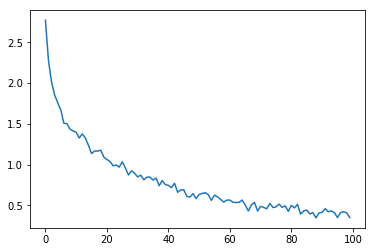

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

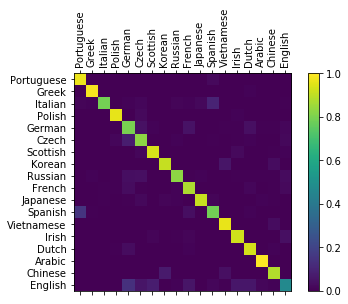

In [10]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = lstm.initRecurrentLayers()

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i])

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = argMax(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [11]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(wordToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.05) Russian
(-3.06) Czech
(-6.60) English

> Jackson
(-0.02) Scottish
(-4.04) English
(-6.27) Czech

> Satoshi
(-0.00) Japanese
(-6.46) Arabic
(-8.86) Russian
